In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

%matplotlib inline

plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

import skimage.io
from skimage.transform import resize

from tqdm import tqdm_notebook

In [18]:
### Here we load in all the relevant neural network packages ###
import tensorflow as tf

# from keras.applications import xception, vgg16, vgg19, mobilenet
# from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Input, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.utils import np_utils, multi_gpu_model
# from keras.optimizers import SGD, Adam
# from keras.datasets import mnist
from keras import backend as K
# from keras import applications
from keras.preprocessing.image import ImageDataGenerator

from AdamW import AdamW

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

In [5]:
def IoU(x,y):
    '''
    version of IoU that uses np.bincount to get the value counts
    
    x and y are both numpy N x M masks
    
    x = proposed mask
    y = ground truth mask
    
    0 for a pixel indicates the mask is blocked, 1 indicates the mask is not blocked.
    In plain English, everywhere that is 1 we can see the cell, everywhere that is 0 we cannot.
    
    We want to calculate the IoU statistic, which is intersection(x,y)/union(x,y) at values where x or y is 1 
    
    By subtracting the proposed mask from 2 x the ground truth mask (i.e. blocked is 0, not blocked is 2),
    then adding 1, we get unique values for each type of overlap situation, plus all values are positive, which
    is required to use np.bincount:
    
INDX  0  1  2  3  4  5  6  7  8  9 10 11

GT    0  0  0  2  2  2  2  2  0  0  0  0
MSK - 0  0  1  1  1  1  0  1  1  0  0  0  
      ----------------------------------
      0  0 -1  1  1  1  2  1 -1  0  0  0
    + 1  1  1  1  1  1  1  1  1  1  1  1
      ----------------------------------
      1  1  0  2  2  2  3  2  0  1  1  1
      
    0: the proposed mask had a pixel, ground truth did not (include in union)   
    1: neither mask had a pixel (don't include)
    2: the proposed mask had a pixed, the ground truth had a pixel (include in intersection and union)
    3: the proposed mask did not have a pixel, the ground truth did (include in union)
    
    np.bincount always has length of np.amax(x) + 1, so we just need to do length checking
    '''
    x = x
    y = y * 2
    
    diff = np.bincount((y - x + 1).flatten())
    diff_len = len(diff)
    
    ### Cacluate the intersection first
    intersection = 0
    if (diff_len >= 3):
        intersection = diff[2]
    
    ### Now calculate the union
    union = intersection
    if diff_len == 4:
        union += diff[3]
    union += diff[0]
        
    if union==0:
        iou = 0 ### default value, we could potentially return blank masks, although GT should never be empty
    else:
        iou = float(intersection) / union

    return iou

def pred_to_binary_mask(pred, threshold):
    tst = np.zeros((pred.shape[0],pred.shape[1]), dtype=np.int8)
    tst[pred >= threshold] = 1
    return tst
    
def calc_iou(pred, gt, threshold):
    pred_mask = pred_to_binary_mask(pred, threshold)
    if (pred_mask.sum()==0) and (gt.sum()==0):
        IoU_value = 1
    elif pred.sum==0 and mask.sum()!=0:
        IoU_value = 0
    else:
        IoU_value = IoU(pred_mask,gt)
    return IoU_value

def calc_avg_precision(pred_mask, gt_mask, threshold, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    ### First calculate the IoU matrix
    iou = calc_iou(pred_mask, gt_mask, threshold)
    
    avg_precision = (iou_thresholds < iou).sum() / len(iou_thresholds)
        
    return avg_precision

In [6]:
class TTA_ModelWrapper():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in tqdm_notebook(X):
            tmp = x_i
            p0 = self.model.predict(tmp.reshape(1,128,128,1))
            p1 = self.model.predict(np.fliplr(tmp).reshape(1,128,128,1))
#             p2 = self.model.predict(np.flipud(tmp).reshape(1,128,128,1))
#             p3 = self.model.predict(np.fliplr(np.flipud(tmp)).reshape(1,128,128,1))
            p = (p0[0] +
                 np.fliplr(p1[0]) #+
#                  np.flipud(p2[0]) +
#                  np.fliplr(np.flipud(p3[0]))
                 ) / 2#4
            pred.append(p)
        return np.array(pred)
    
class TTA_ModelWrapper_3channel():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in tqdm_notebook(X):
            tmp = x_i
            p0 = self.model.predict(tmp.reshape(1,128,128,3))
            p1 = self.model.predict(np.fliplr(tmp).reshape(1,128,128,3))
#             p2 = self.model.predict(np.flipud(tmp).reshape(1,128,128,1))
#             p3 = self.model.predict(np.fliplr(np.flipud(tmp)).reshape(1,128,128,1))
            p = (p0[0] +
                 np.fliplr(p1[0]) #+
#                  np.flipud(p2[0]) +
#                  np.fliplr(np.flipud(p3[0]))
                 ) / 2#4
            pred.append(p)
        return np.array(pred)

In [7]:
def load_image(path):
    img = skimage.io.imread(path, as_grey=True)
    return img

def load_mask(path):
    mask = skimage.io.imread(path, as_grey=True)
    mask = mask / 65535
    return mask

def biggenate(x):
    target_image_size = (128,128,1)
    return resize(x, target_image_size, mode='constant', preserve_range=True)

def smallenate(x):
    target_image_size = (101,101)
    return resize(x, target_image_size, mode='constant', preserve_range=True)

def biggenate_zero_pad(x):
    target_image_size = (128,128,1)
    new_image = np.zeros((target_image_size[0], target_image_size[1], target_image_size[2]), dtype=np.float64)
    new_image[13:114,13:114, 0] = x
    return new_image

def smallenate_zero_pad(x):
    new_image = x[13:114,13:114]
    return new_image

In [8]:
class LearningRateHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.lr.append(K.eval(self.model.optimizer.lr))

### Load in the training/validation data

In [9]:
### Load in the whole list then eliminate those that are bad ###
traindir = '../../train/'
all_image_files = np.array(os.listdir(filter_directory_list(traindir + 'images/')))

# ### Find out which images are blanks, eliminate them from the training set list ###
# image_sums = np.array([skimage.io.imread(traindir + 'images/' + x).sum() for x in tqdm_notebook(all_image_files)])
# good_training_images = all_image_files[np.argwhere(image_sums > 1000).reshape(-1)]

good_training_images = all_image_files

### Load in the images ###
# images = np.array([load_image(traindir + 'images/' + x) for x in tqdm_notebook(good_training_images)])
images_orig = np.array([load_image(traindir + 'images/' + x) for x in tqdm_notebook(good_training_images)])
masks_orig = np.array([load_mask(traindir + 'masks/' + x) for x in tqdm_notebook(good_training_images)])

In [10]:
### Run this to mean center the images ###
images_orig_m1_to_1 = np.array([x - x.mean() for x in images_orig])

# ### Run this to make the images be from -1 to 1, after mean centering
# images_orig_max_m1_to_1 = np.abs(images_orig_m1_to_1).max(axis=(1,2))
# for i in range(len(images_orig_m1_to_1)):
#     if images_orig_max_m1_to_1[i]!=0:
#         images_orig_m1_to_1[i] = images_orig_m1_to_1[i] / images_orig_max_m1_to_1[i]
        
# images_orig_std = np.array([x - x.mean() for x in images_orig])
# images_orig_std = np.array([x / x.std() if x.std()!=0 else x for x in images_orig_std])
# images_orig_std = images_orig_std / np.abs(images_orig_std).max()

In [11]:
# images_orig.min(), images_orig.max(), images_orig_m1_to_1.min(), images_orig_m1_to_1.max(), images_orig_std.min(), images_orig_std.max()

In [12]:
images_orig.shape

(4000, 101, 101)

In [13]:
# plt.plot(sums[(sums > 1900) & (sums < 8000)], 'o'); plt.ylim([-300,12000]); plt.show()
# plt.plot(sums,'o'); plt.show()

In [14]:
# ### Run this to eliminate the extremes ###
# images_orig = images_orig[(sums > 1900) & (sums < 8000)]
# masks_orig = masks_orig[(sums > 1900) & (sums < 8000)]

In [15]:
### Run this to expand the image ###
# images = np.array([biggenate(x) for x in tqdm_notebook(images_orig)])
# masks = np.array([biggenate(x) for x in tqdm_notebook(masks_orig)])

# ### Run this to zero pad the image ###
# images = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_orig)])

### Run this to use -1 to 1 images ###
images = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_orig_m1_to_1)])

# ### Run this to use standardized images ###
# images = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_orig_std)])

# # ### Run this to add three channels ###
# images_0_to_1 = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_orig)])
# images_m1_to_1 = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_orig_m1_to_1)])
# images_std = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_orig_std)])
masks = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(masks_orig)])

# images = np.zeros((images_0_to_1.shape[0], images_0_to_1.shape[1], images_0_to_1.shape[2], 3))
# images[:,:,:,0] = images_0_to_1.squeeze()
# images[:,:,:,1] = images_m1_to_1.squeeze()
# images[:,:,:,2] = images_std.squeeze()

Calculate mask coverage to do the stratified sampling, as inspired by https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

In [16]:
### Calculate the mask coverage to do stratified sampling ###
### Find the area of the grid ###
area = masks_orig.shape[1] * masks_orig.shape[2]

### Find the fractional covereage of each mask (they are already normalized to [0,1]) ###
coverage = masks_orig.sum(axis=(1,2)) / area

### Cast into a category every 0.1 coverage. 0 coverage gets its own class too ###
coverage_category = np.ceil(coverage * 10)

Split into the training and validation sets

In [17]:
# train_images, val_images, train_masks, val_masks, train_orig_masks, val_orig_masks, \
# train_image_files, val_image_files, train_indices, val_indices = train_test_split(images, masks, \
#                                                                             masks_orig, good_training_images, \
#                                                                             range(len(good_training_images)), \
#                                                                              stratify=coverage_category, \
#                                                                              test_size=0.2, random_state=42)

### Produce the UNet model

In [19]:
def unet_model(filter_scaling=16, depth=5):

    input_layer = Input((128,128,1))

    conv_initialization_dict = {"activation":'relu', 
                                "padding":'same',
                                "kernel_initializer" : 'he_normal'}

    conv_initialization_dict_no_activation = {"padding":'same',
                                "kernel_initializer" : 'he_normal'}

    conv_dict = {}
    for i in range(1,depth):
        if i==1:
            x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(input_layer)
        else:
            x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(x)
        x = Activation('relu')(x)     
        x = BatchNormalization(momentum=0.8)(x)
    #     x = Dropout(0.2)(x)
    #     x = Dropout(0.25)(x)
        conv_dict[i] = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.8)(x)
    #     x = Dropout(0.2)(x)

        x = MaxPooling2D((2,2), padding='same')(conv_dict[i])


    ### The bottom of the network ###
    x = Conv2D((2**(depth-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D((2**(depth-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
    x = BatchNormalization(momentum=0.8)(x)

    for i in range(depth-1,0,-1):

        x = Conv2DTranspose((2**(i-1)) * filter_scaling, (3,3), strides=(2,2), **conv_initialization_dict)(x)
        x = concatenate([conv_dict[i], x])
        x = BatchNormalization(momentum=0.7)(x)
        x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
        x = BatchNormalization(momentum=0.8)(x)
    #     x = Dropout(0.2)(x)
        x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
        if i!=1:
            x = BatchNormalization(momentum=0.8)(x)
    #         x = Dropout(0.2)(x)

    output_layer = Conv2D(1, (1,1), activation='sigmoid', padding='same')(x)

    model = Model(input_layer, output_layer)

    adamw = AdamW(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0., weight_decay=0.025)#, batch_size=1, samples_per_epoch=1, epochs=1)
    model.compile(loss="binary_crossentropy", optimizer=adamw, metrics=["accuracy"])

    return model

# model.summary()

In [20]:
# model = unet_model(filter_scaling=64, depth=depth)
# model.summary()

In [24]:
# filter_scalings = [8, 16, 32]
# depths = [3, 4, 5, 6]
depths = [5]
# filter_scalings = [64, 128]
filter_scalings = [48]
# depths = [4, 5]
# batch_sizes = [32, 64, 128]
batch_sizes = [64]
number_folds = range(1,5)

record_file = "adamw_test_1.csv"
# if os.path.exists(record_file):
#     raise ValueError("Record file already exists")
    
# with(open(record_file,'w')) as f:
#     f.write('filter_scaling,depth,batchsize,fold,highest_val_acc,lowest_val_loss,threshold_max,mAP_max,threshold_max_augmentation,mAP_max_augmentation')

for filter_scaling in filter_scalings:
    for depth in depths:
        for batch_size in batch_sizes:
            for fold in number_folds:

                ##########################################################################################
                ###### Create the current train / test setups ###########################################
                ########################################################################################

                train_images, val_images, train_masks, val_masks, train_orig_masks, val_orig_masks, \
                train_image_files, val_image_files, train_indices, val_indices = train_test_split(images, masks, \
                                                                                            masks_orig, good_training_images, \
                                                                                            range(len(good_training_images)), \
                                                                                             stratify=coverage_category, \
                                                                                             test_size=0.2)

                ##########################################################################################
                ##### Create all generators #############################################################
                ########################################################################################

                generator_dict = {'horizontal_flip': True}

                image_datagen = ImageDataGenerator(**generator_dict)
                mask_datagen = ImageDataGenerator(**generator_dict)

                image_generator = image_datagen.flow(
                        train_images,
                        batch_size=batch_size,
                        seed=1)

                mask_generator = mask_datagen.flow(
                        train_masks,
                        batch_size=batch_size,
                        seed=1)

                combined_generator = zip(image_generator, mask_generator)

                ### Load the current model ###
                model = unet_model(filter_scaling=filter_scaling, depth=depth)

                ### Name the model ###
                model_file = "./unet_models/unet_adamw_fs_" + str(filter_scaling) + \
                             "_d_" + str(depth) + "_bs_" + str(batch_size) + "_fold_" + str(fold)
                if os.path.exists(model_file):
                    raise ValueError("Model file already exists")

                ### Set up model training parameters ###
                early_stopping = EarlyStopping(patience=12, verbose=1)
                model_checkpoint = ModelCheckpoint(model_file, save_best_only=True, verbose=1)
                reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6, verbose=1)
                learning_rec= LearningRateHistory()

                ### Fit the model ###
#                 history = model.fit_generator(combined_generator, train_images.shape[0] // batch_size, \
#                                               epochs=200, verbose=1, validation_data=(val_images, val_masks),
#                                               callbacks=[early_stopping, model_checkpoint, reduce_lr, learning_rec])
                history = model.fit_generator(combined_generator, train_images.shape[0] // batch_size, \
                                              epochs=200, verbose=1, validation_data=(val_images, val_masks),
                                              callbacks=[early_stopping, model_checkpoint, learning_rec])

                ### Load back in the best model ###
                model_to_load = model_file
                model.load_weights(model_to_load)

                ################################################################################
                ### Print out the history to file #############################################
                ##############################################################################
                df = pd.DataFrame()
                df['epoch'] = history.epoch
                df['loss'] = history.history['loss']
                df['acc'] = history.history['acc']
                df['val_loss'] = history.history['val_loss']
                df['val_acc'] = history.history['val_acc']
                df['lr'] = learning_rec.lr
                df.to_csv(model_file+'_history.csv',index=False)

                ###############################################################################
                ### Extract best parameters ##################################################
                #############################################################################
                highest_val_acc = history.history['val_acc'][np.argmax(history.history['val_acc'])]
                lowest_val_loss = history.history['val_loss'][np.argmin(history.history['val_loss'])]

                ###############################################################################
                ### Do prediction without augmentation #######################################
                #############################################################################

                preds = model.predict(val_images)

                ### Use this when working with zero padded images ###
                preds_orig = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds.squeeze())])

                # Running on 10 images. Increase for better accuracy.
                thresholds = np.linspace(0, 1.0, 50)
                iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

                mAPs = []
                for threshold in tqdm_notebook(thresholds):
                    APs = []
                    for i in range(len(preds)):
                        image = val_images[i]
                        ### Need this if/else if you eliminated samples with sum()==0
                        if image.sum()==0:
                            pred = np.zeros((101,101))
                            mask = val_orig_masks[i].squeeze().astype(np.int8)

                            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
                        else:
                            pred = preds_orig[i]
                            mask = val_orig_masks[i].squeeze().astype(np.int8)

                            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

                        APs.append(AP)

                    mAPs.append(np.mean(APs))

                threshold_max = thresholds[np.argmax(mAPs)]
                mAP_max = mAPs[np.argmax(mAPs)]

                ###############################################################################
                ### Do prediction with augmentation ##########################################
                #############################################################################

                tta = TTA_ModelWrapper(model)
                preds = tta.predict(val_images)

                ### Use this when working with zero padded images ###
                preds_orig = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds.squeeze())])

                # Running on 10 images. Increase for better accuracy.
                thresholds = np.linspace(0, 1.0, 50)
                iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

                mAPs = []
                for threshold in tqdm_notebook(thresholds):
                    APs = []
                    for i in range(len(preds)):
                        image = val_images[i]
                        ### Need this if/else if you eliminated samples with sum()==0
                        if image.sum()==0:
                            pred = np.zeros((101,101))
                            mask = val_orig_masks[i].squeeze().astype(np.int8)

                            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
                        else:
                            pred = preds_orig[i]
                            mask = val_orig_masks[i].squeeze().astype(np.int8)

                            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

                        APs.append(AP)

                    mAPs.append(np.mean(APs))

                threshold_max_augmentation = thresholds[np.argmax(mAPs)]
                mAP_max_augmentation = mAPs[np.argmax(mAPs)]

                #################################################################################################
                ##### Write the parameters out to file #########################################################
                ###############################################################################################

                output_vector = [filter_scaling,depth,batch_size,fold,highest_val_acc,lowest_val_loss] + \
                                [threshold_max,mAP_max,threshold_max_augmentation,mAP_max_augmentation]
                output_string = ','.join(list(np.array(output_vector).astype('str')))

                with(open(record_file,'a')) as f:
                    f.write('\n')
                    f.write(output_string)

Epoch 1/200
50/50 [==============================] - 36s 720ms/step - loss: 0.2676 - acc: 0.9040 - val_loss: 0.3829 - val_acc: 0.8447

Epoch 00001: val_loss improved from inf to 0.38293, saving model to ./unet_models/unet_adamw_fs_48_d_5_bs_64_fold_1
Epoch 2/200
50/50 [==============================] - 30s 602ms/step - loss: 0.3227 - acc: 0.9052 - val_loss: 0.4444 - val_acc: 0.8448

Epoch 00002: val_loss did not improve
Epoch 3/200
50/50 [==============================] - 31s 613ms/step - loss: 0.3759 - acc: 0.8812 - val_loss: 0.4776 - val_acc: 0.8447

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 31s 611ms/step - loss: 0.3514 - acc: 0.8459 - val_loss: 0.4362 - val_acc: 0.8447

Epoch 00004: val_loss did not improve
Epoch 5/200
50/50 [==============================] - 31s 616ms/step - loss: 0.3589 - acc: 0.8459 - val_loss: 0.4374 - val_acc: 0.8447

Epoch 00005: val_loss did not improve
Epoch 6/200
50/50 [==============================] - 31s 


Epoch 1/200
50/50 [==============================] - 37s 734ms/step - loss: 0.2660 - acc: 0.9060 - val_loss: 0.4347 - val_acc: 0.8460

Epoch 00001: val_loss improved from inf to 0.43467, saving model to ./unet_models/unet_adamw_fs_48_d_5_bs_64_fold_2
Epoch 2/200
50/50 [==============================] - 31s 615ms/step - loss: 0.3119 - acc: 0.9117 - val_loss: 0.3988 - val_acc: 0.8981

Epoch 00002: val_loss improved from 0.43467 to 0.39876, saving model to ./unet_models/unet_adamw_fs_48_d_5_bs_64_fold_2
Epoch 3/200
50/50 [==============================] - 31s 616ms/step - loss: 0.3903 - acc: 0.8913 - val_loss: 0.4035 - val_acc: 0.8460

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 31s 615ms/step - loss: 0.3785 - acc: 0.8459 - val_loss: 0.3610 - val_acc: 0.8460

Epoch 00004: val_loss improved from 0.39876 to 0.36102, saving model to ./unet_models/unet_adamw_fs_48_d_5_bs_64_fold_2
Epoch 5/200
50/50 [==============================] - 31s 616ms/st


Epoch 1/200
50/50 [==============================] - 37s 747ms/step - loss: 0.3000 - acc: 0.8936 - val_loss: 0.4227 - val_acc: 0.8459

Epoch 00001: val_loss improved from inf to 0.42270, saving model to ./unet_models/unet_adamw_fs_48_d_5_bs_64_fold_3
Epoch 2/200
50/50 [==============================] - 31s 614ms/step - loss: 0.3587 - acc: 0.9081 - val_loss: 0.4675 - val_acc: 0.8459

Epoch 00002: val_loss did not improve
Epoch 3/200
50/50 [==============================] - 31s 615ms/step - loss: 0.4505 - acc: 0.8662 - val_loss: 0.6250 - val_acc: 0.8459

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 31s 616ms/step - loss: 0.4288 - acc: 0.8455 - val_loss: 0.4484 - val_acc: 0.8459

Epoch 00004: val_loss did not improve
Epoch 5/200
50/50 [==============================] - 31s 617ms/step - loss: 0.4186 - acc: 0.8455 - val_loss: 0.4599 - val_acc: 0.8459

Epoch 00005: val_loss did not improve
Epoch 6/200
50/50 [==============================] - 31s


Epoch 1/200
50/50 [==============================] - 38s 754ms/step - loss: 0.2720 - acc: 0.9053 - val_loss: 0.4243 - val_acc: 0.8460

Epoch 00001: val_loss improved from inf to 0.42432, saving model to ./unet_models/unet_adamw_fs_48_d_5_bs_64_fold_4
Epoch 2/200
50/50 [==============================] - 31s 615ms/step - loss: 0.3158 - acc: 0.9110 - val_loss: 0.4284 - val_acc: 0.8460

Epoch 00002: val_loss did not improve
Epoch 3/200
50/50 [==============================] - 31s 616ms/step - loss: 0.4010 - acc: 0.8798 - val_loss: 0.4625 - val_acc: 0.8460

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 31s 614ms/step - loss: 0.3871 - acc: 0.8455 - val_loss: 0.3857 - val_acc: 0.8460

Epoch 00004: val_loss improved from 0.42432 to 0.38570, saving model to ./unet_models/unet_adamw_fs_48_d_5_bs_64_fold_4
Epoch 5/200
50/50 [==============================] - 31s 617ms/step - loss: 0.3760 - acc: 0.8455 - val_loss: 0.5673 - val_acc: 0.8460

Epoch 00005:

### Create a submission

In [32]:
filter_scaling = 48
depth = 5
batch_size = 64
fold = 2
model = unet_model(filter_scaling=filter_scaling, depth=depth)
model_file = "./unet_models/unet_auto_param_search_fs_" + str(filter_scaling) + \
                         "_d_" + str(depth) + "_bs_" + str(batch_size) + "_fold_" + str(fold)

In [33]:
model_to_load = model_file
model.load_weights(model_to_load)
high_threshold = 0.673469

In [34]:
def mask_to_rle(mask):
    """Takes a mask that is nxm, represented as 0 and integers, or as Boolean,
    and converts it to run length encoding."""
    mask = np.transpose(mask)
    mask = mask.astype(np.bool).astype('int')
    mask = mask.reshape(-1)

    dummy = np.insert(mask, 0, 0)
    mask = np.insert(mask, len(mask), 0)

    diff = dummy - mask
    
    diffindx = np.argwhere(diff!=0)
    
    starts = diffindx[::2] + 1 # it is one indexed so need this
    
    runs = diffindx[1::2] - diffindx[::2]
    
    run_length_encoded = np.hstack((starts, runs)).reshape(-1)
    
    return run_length_encoded

In [27]:
### Load in the whole list then eliminate those that are bad ###
testdir = '../../test/'
all_image_files = np.array(os.listdir(filter_directory_list(testdir + 'images/')))
good_test_images = all_image_files

### Load in the images ###
images_test_orig = np.array([load_image(testdir + 'images/' + x) for x in tqdm_notebook(good_test_images)])

### Use this for expansion trained models ###
# images_test = np.array([biggenate(x) for x in tqdm_notebook(images_test_orig)])

### Use this to mean center ###
images_test_orig = np.array([x - x.mean() for x in images_test_orig])

### Use this for zero pad trained models ###
images_test = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_test_orig)])

In [35]:
### Do the model predictions
tta = TTA_ModelWrapper(model)
preds_test = tta.predict(images_test)

# preds_test = model.predict(images_test)

### Use this for expansion trained models ###
# preds_test_orig = np.array([smallenate(x) for x in tqdm_notebook(preds_test.squeeze())])

### Use this for zero pad trained models ###
preds_test_orig = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test.squeeze())])

# preds_test_masks = np.array([pred_to_binary_mask(x, thresholds[np.argmax(mAPs)]) for x in tqdm_notebook(preds_test_orig)])
preds_test_masks = np.array([pred_to_binary_mask(x, high_threshold) for x in tqdm_notebook(preds_test_orig)])

In [36]:
submission_file = '../submissions/' + model_file.split('/')[-1]#unet_preprocessing_3_submission'

In [37]:
with(open(submission_file,'w')) as f:
    f.write('id,rle_mask')
    
    for i in tqdm_notebook(range(len(good_test_images))):
        image_name = good_test_images[i].split('.')[0]
        pred_mask = preds_test_masks[i,:,:]
        if pred_mask.sum()==0:
            f.write('\n')
            f.write(image_name + ',')
        elif images_test_orig[i].sum()==0:
            f.write('\n')
            f.write(image_name + ',')
        else:
            pred_mask_rle = mask_to_rle(pred_mask)
            f.write('\n')
            f.write(image_name + ',' + ' '.join(list(pred_mask_rle.astype('str'))))

In [74]:
sums_test = images_test_orig.sum(axis=(1,2))

In [77]:
sums_test[sums_test==0].shape[0] / images_test_orig.shape[0]

0.02388888888888889

In [78]:
sums = images_orig.sum(axis=(1,2))

In [79]:
sums[sums==0].shape[0] / images.shape[0]

0.02

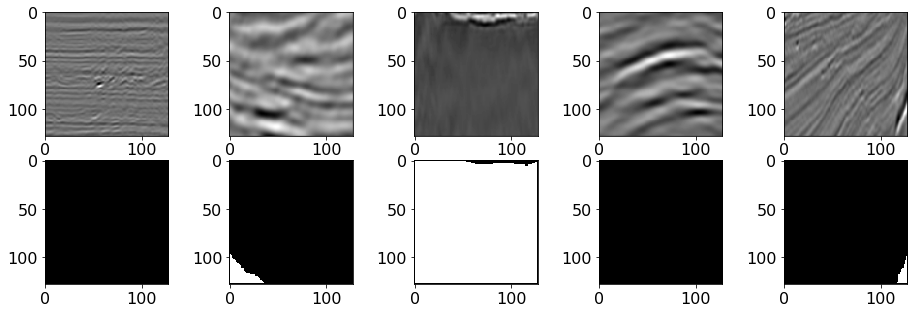

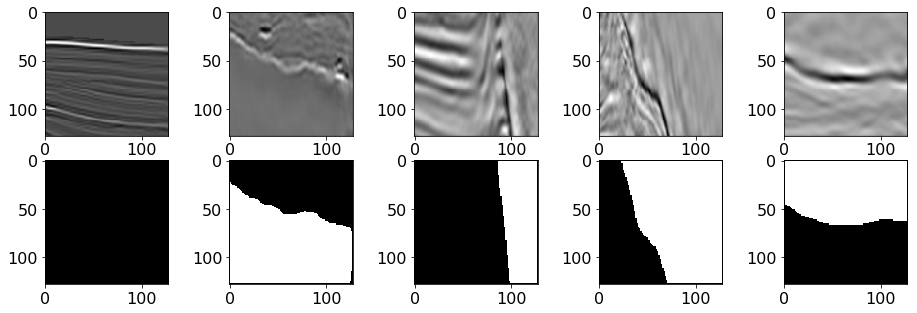

In [148]:
plt.figure(figsize=(16,5))
num_images = 5
for i in range(num_images):
    curr_image = images[i,:,:,0]
    curr_mask  = masks[i,:,:,0]
    
    plt.subplot(2,num_images,i+1); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(curr_mask, cmap='gray')
    
plt.figure(figsize=(16,5))
for i in range(num_images,2*num_images):
    curr_image = images[i,:,:,0]
    curr_mask  = masks[i,:,:,0]
    
    plt.subplot(2,num_images,i+1 - num_images); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1 - num_images); 
    plt.imshow(curr_mask, cmap='gray')

### Let's copy what he did, see if I can figure out what is going on with my training/test images. I think this is why it's not training up

In [77]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

In [57]:
img_size_ori = 101
img_size_target = 128

In [58]:
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [3]:
train_df = pd.read_csv("../../train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../../depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [4]:
train_df["images"] = [np.array(load_img("../../train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img("../../train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [7]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

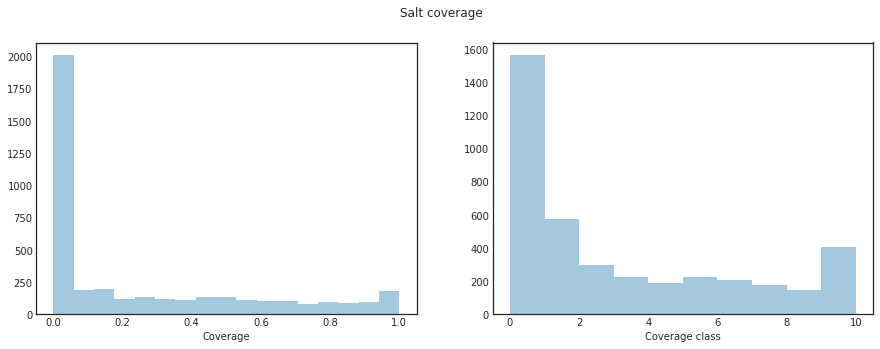

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

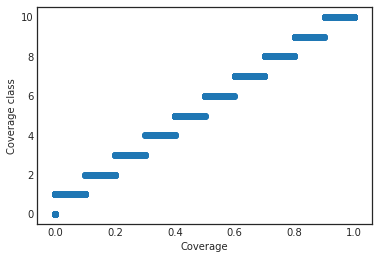

In [9]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

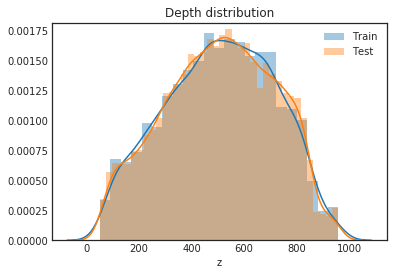

In [10]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

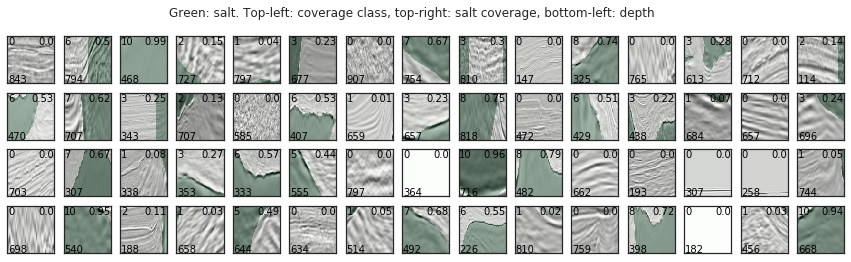

In [11]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [12]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5,1,'Scaled image')

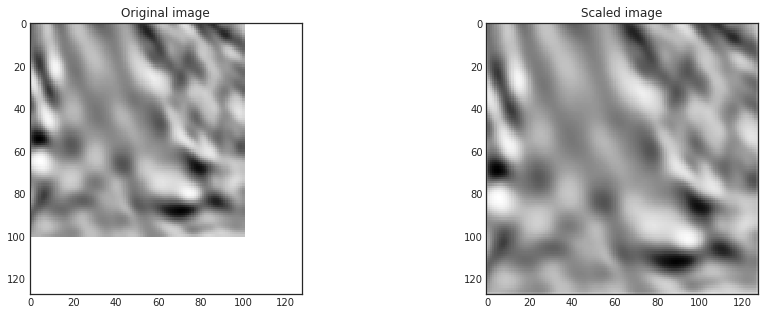

In [13]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

In [80]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

model = Model(input_layer, output_layer)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [83]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
dropout_1 

In [72]:
batch_size = 32

history = model.fit(images, train_masks,
                    validation_data=[val_images, val_masks], 
                    epochs=20,
                    batch_size=batch_size)

# history = model.fit(x_train, y_train,
#                     validation_data=[x_valid, y_valid], 
#                     epochs=40,
#                     batch_size=batch_size)

Train on 3136 samples, validate on 784 samples
Epoch 1/40
3136/3136 [==============================] - 13s 4ms/step - loss: 0.5656 - acc: 0.7356 - val_loss: 0.5152 - val_acc: 0.7492
Epoch 2/40
3136/3136 [==============================] - 11s 4ms/step - loss: 0.4754 - acc: 0.7584 - val_loss: 0.4287 - val_acc: 0.7827
Epoch 3/40
3136/3136 [==============================] - 11s 3ms/step - loss: 0.4212 - acc: 0.8254 - val_loss: 0.3812 - val_acc: 0.8440
Epoch 4/40
3136/3136 [==============================] - 11s 3ms/step - loss: 0.3904 - acc: 0.8402 - val_loss: 0.3603 - val_acc: 0.8485
Epoch 5/40
3136/3136 [==============================] - 11s 3ms/step - loss: 0.3656 - acc: 0.8546 - val_loss: 0.3317 - val_acc: 0.8720
Epoch 6/40
3136/3136 [==============================] - 11s 4ms/step - loss: 0.3352 - acc: 0.8708 - val_loss: 0.3329 - val_acc: 0.8695
Epoch 7/40
3136/3136 [==============================] - 11s 4ms/step - loss: 0.3398 - acc: 0.8642 - val_loss: 0.3132 - val_acc: 0.8838
Epoch 8/

In [51]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

In [59]:
preds_valid = model.predict(val_images).reshape(-1, 128, 128)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in val_masks])#np.array([train_df.loc[idx].masks for idx in ids_valid])

In [82]:
y_valid_ori.shape

(784, 101, 101, 1)

(array([9.802219e+06, 1.034700e+04, 9.064000e+03, 9.447000e+03,
        9.273000e+03, 8.913000e+03, 8.698000e+03, 9.123000e+03,
        1.093960e+05, 3.130720e+06]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

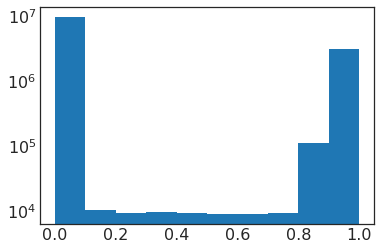

In [64]:
plt.hist(y_valid_ori.reshape(-1), log=True)

(array([6126474.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 2034326.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

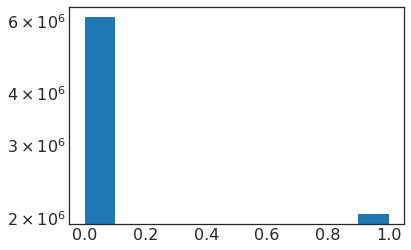

In [63]:
plt.hist(y_valid_ori.reshape(-1), log=True)

In [83]:
y_valid.dtype, y_valid_ori.dtype

(dtype('float64'), dtype('float64'))

In [60]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [76]:
# thresholds = np.linspace(0, 1, 50)
# ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [84]:
preds_valid.shape, y_valid_ori.shape

((784, 101, 101), (784, 101, 101, 1))

In [61]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori.squeeze(), np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [62]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

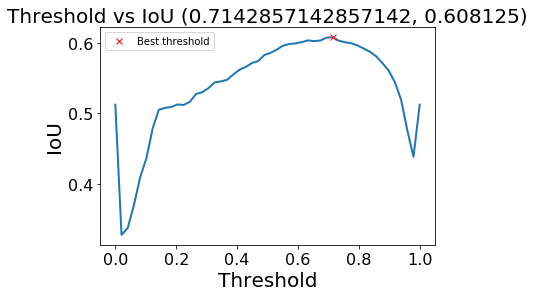

In [63]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [19]:
%%time
preds = model.predict(x_valid)

CPU times: user 5.47 s, sys: 488 ms, total: 5.96 s
Wall time: 1.11 s


In [21]:
preds.shape

(800, 128, 128, 1)

In [22]:
preds = preds.squeeze()

In [23]:
preds.shape

(800, 128, 128)

In [24]:
y_valid.shape

(800, 128, 128, 1)

In [28]:
y_valid.dtype

dtype('float64')

In [29]:
np.unique(y_valid)

array([0.00000000e+00, 1.52587891e-05, 4.57763672e-05, ...,
       9.99984741e-01, 9.99984741e-01, 1.00000000e+00])

(array([9.802219e+06, 1.034700e+04, 9.064000e+03, 9.447000e+03,
        9.273000e+03, 8.913000e+03, 8.698000e+03, 9.123000e+03,
        1.093960e+05, 3.130720e+06]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

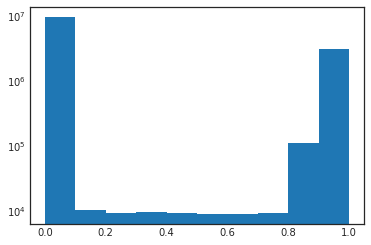

In [32]:
plt.hist(y_valid.reshape(-1), log=True)

In [90]:
# Running on 10 images. Increase for better accuracy.
thresholds = np.linspace(0, 1.0, 50)
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

mAPs = []
for threshold in tqdm_notebook(thresholds):
    APs = []
    for i in range(len(preds_valid)):
        pred = preds_valid[i]
        mask = y_valid_ori[i].squeeze().astype(np.int8)

        AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
    #     if (mask.sum()==0) and (pred.sum()==0):
    #         AP = 1.0
    #     elif (mask.sum()==0) and (pred.sum()!=0):
    #         AP = 0.0
    #     else:
    #     AP = calc_iou(pred, mask, 0.2)

        APs.append(AP)
    #         precs.append(precisions)
    mAPs.append(np.mean(APs))

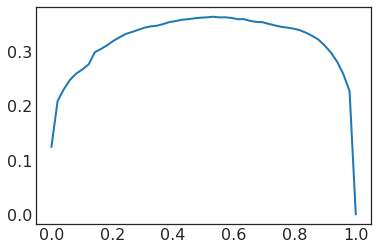

In [91]:
plt.plot(thresholds, mAPs)

In [91]:
x_train.shape, y_train.shape

((3200, 128, 128, 1), (3200, 128, 128, 1))

In [92]:
train_images.shape, train_masks.shape

(3136, 128, 128, 1)

In [94]:
x_train.max()

1.0

In [95]:
x_train.min()

0.0

(array([ 1219722.,   953500.,  3979355., 10483119., 13961241., 11500404.,
         6833755.,  2582119.,   679858.,   235727.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

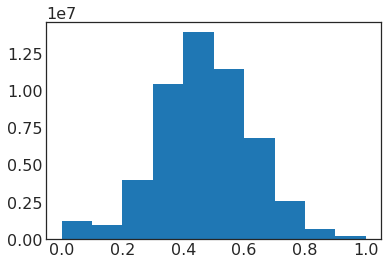

In [97]:
plt.hist(x_train.reshape(-1))

In [99]:
y_train.max(), y_train.min()

(1.0, 0.0)

(array([3.9298886e+07, 4.0603000e+04, 3.5761000e+04, 3.5707000e+04,
        3.5299000e+04, 3.3754000e+04, 3.6626000e+04, 3.5644000e+04,
        4.3894400e+05, 1.2437576e+07]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

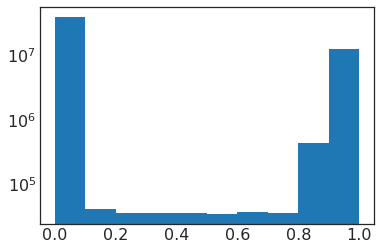

In [58]:
plt.hist(y_train.reshape(-1), log=True)

(array([38606379.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 12773845.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

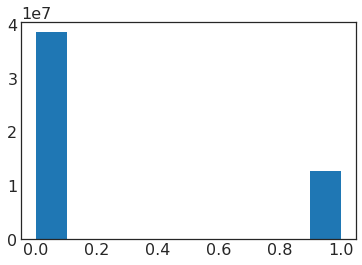

In [101]:
plt.hist(train_masks.reshape(-1))